In [174]:
using DataFrames, CSV, Plots
include("/Users/johnbuckner/.julia/dev/UniversalDiffEq.jl/src/UniversalDiffEq.jl")


Main.UniversalDiffEq

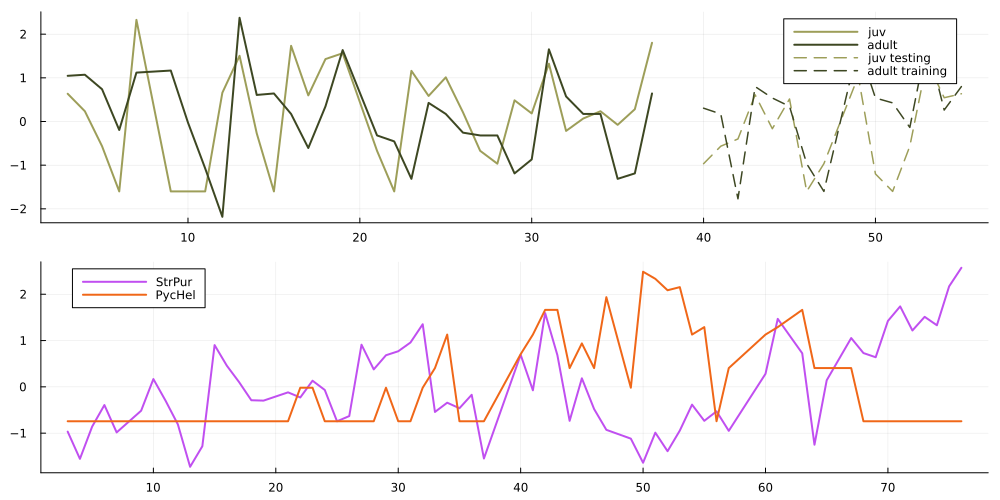

In [175]:
site = 4
dat = CSV.read("../data/processed_time_series.csv", DataFrame)[:,2:end]
dat = sort(dat,:PERIOD)

dat_states = dat[dat.SITE .== site,[:PERIOD,:MacJuv,:MacPyr]]
training = dat_states[dat_states.PERIOD .< 40,:]
testing = dat_states[(dat_states.PERIOD .>= 40) .& (dat_states.PERIOD .<= 55),:]
validation = dat_states[dat_states.PERIOD .> 55,:]

X = dat[dat.SITE .== site,[:PERIOD,:MesFra,:StrPur,:PteCal,:PycHel,:SemPul]]



p1 = Plots.plot(training.PERIOD, training.MacJuv, label = "juv", width = 2, color = "#9d9e59" )
Plots.plot!(training.PERIOD, training.MacPyr, label = "adult", width = 2, color = "#3d4722")
Plots.plot!(testing.PERIOD, testing.MacJuv, label = "juv testing", width = 1.5, linestyle = :dash, color = "#9d9e59")
Plots.plot!(testing.PERIOD, testing.MacPyr, label = "adult training", width = 1.5,linestyle = :dash, color = "#3d4722")
p2 = Plots.plot(X.PERIOD, X.StrPur, label = "StrPur", width = 2, color = "#c04ff0" )
Plots.plot!(X.PERIOD, X.PycHel, label = "PycHel", width = 2, color = "#f06718" )
plot(p1,p2, layout = (2,1), size = (1000,500))

In [176]:
X[1:2,:]

Row,PERIOD,MesFra,StrPur,PteCal,PycHel,SemPul
,Int64,Float64,Float64,Float64,Float64,Float64
1,3,0.481251,-0.966806,0.219836,-0.74234,-1.97455
2,4,-0.0570733,-1.55477,-0.0220743,-0.74234,-2.20364


In [187]:
covars = [2,4,5]

NN, NNparameters = UniversalDiffEq.SimpleNeuralNetwork(2+length(covars),2, hidden = 10, seed = 5491)

function dudt(u,X,p,t,covars)
    return NN(vcat(u,X[covars]), p.NN) # index 3 is pycnopodia  ,X[1:2]
end

init_parameters = (NN = NNparameters, )

NODE = UniversalDiffEq.CustomDerivatives(training,X,(u,X,p,t) -> dudt(u,X,p,t,covars),
                                            init_parameters;time_column_name = "PERIOD")

UniversalDiffEq.train!(NODE, loss_function = "spline gradient matching", 
        regularization_weight = 1e-5, optim_options = (maxiter = 500, step_size = 0.025), 
        loss_options = (σ = 0.05, τ = 0.1, T = 4*size(training)[1]))
nothing

134
41966.122 35873.702 31786.645 29335.286 27970.565 27216.39 26732.443 26312.235 25855.628 25332.561 24748.091 24125.805 23501.097 22910.155 22378.279 21914.288 21511.173 21151.223 20813.875 20483.509 20153.631 19825.691 19504.549 19194.14 18895.601 18607.946 18329.779 18060.349 17799.312 17545.713 17297.106 17049.627 16799.366 16544.461 16286.346 16029.008 15776.715 15531.797 15293.78 15060.152 14827.997 14595.46 14362.346 14129.652 13898.526 13669.589 13443.046 13219.182 12998.515 12781.494 12568.166 12358.195 12151.248 11947.461 11747.619 11552.917 11364.436 11182.745 11007.904 10839.791 10678.395 10523.799 10375.876 10234.018 10097.172 9964.221 9834.376 9707.266 9582.704 9460.401 9339.902 9220.774 9102.8 8985.978 8870.382 8756.069 8643.142 8531.856 8422.597 8315.702 8211.335 8109.543 8010.388 7913.949 7820.233 7729.162 7640.65 7554.602 7470.847 7389.157 7309.359 7231.349 7155.04 7080.37 7007.35 6936.017 6866.344 6798.258 6731.701 6666.614 6602.894 6540.428 6479.125 6418.911 6359.

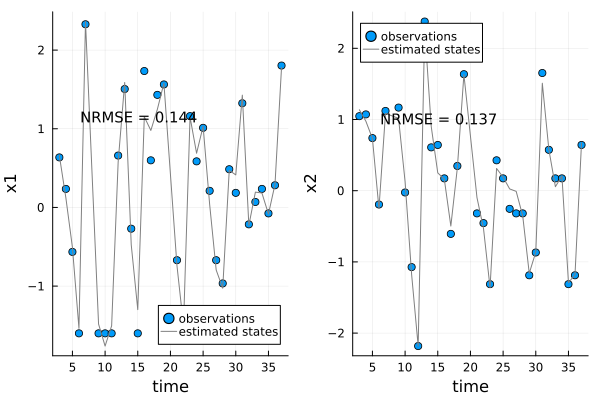

In [188]:
UniversalDiffEq.plot_state_estimates(NODE)

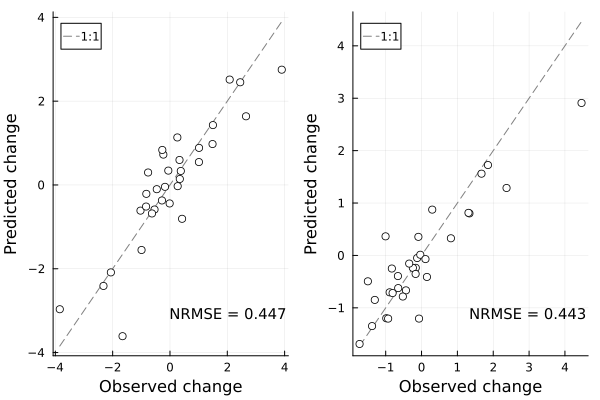

In [189]:
UniversalDiffEq.plot_predictions(NODE)

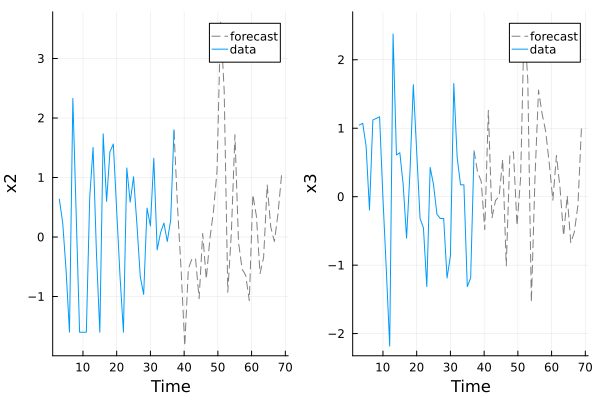

In [190]:
plt,(p1,p2)=UniversalDiffEq.plot_forecast(NODE, 30)
plt

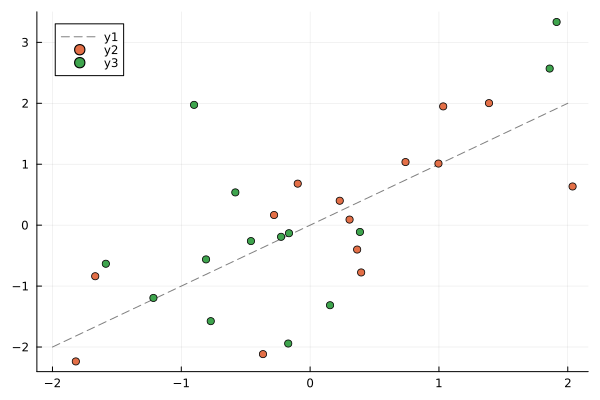

In [195]:
function test_metrics(model,testing) 
    inits,obs,preds = UniversalDiffEq.predictions(model,testing)
    delta_obs = obs .- inits
    delta_pred = preds .- inits

    plt = Plots.plot([-2,2],[-2,2], color = "grey", linestyle = :dash)
    Plots.scatter!(delta_pred[1,:], delta_obs[1,:])
    Plots.scatter!(delta_pred[2,:], delta_obs[2,:])

    cor_juv = cor(delta_obs[1,:], delta_pred[1,:])
    cor_adult =cor(delta_obs[2,:], delta_pred[2,:])
    return cor_juv, cor_adult, plt
end
c1,c2,plt=test_metrics(NODE,testing)
plt 

0.7437915900469091

0.649910962946899